## Data Visualization with Geopandas and Bokeh

Referencing this tutorial: https://towardsdatascience.com/a-complete-guide-to-an-interactive-geographical-map-using-python-f4c5197e23e0

In [48]:
import numpy as np
import pandas as pd
import geopandas as gpd
import json

from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer

import matplotlib.pyplot as plt

In [85]:
shapefile = '/Users/a666/codeup-data-science/flask-project/ne_110m_admin_1_states_provinces/ne_110m_admin_1_states_provinces.shp'

#Read shapefile using Geopandas
gdf = gpd.read_file(shapefile)[['name', 'iso_3166_2', 'geometry']]

#Rename columns.
gdf.columns = ['state', 'state_code', 'geometry']
gdf.head()

,state,state_code,geometry
0,Minnesota,US-MN,"POLYGON ((-89.95766 47.28691, -90.13175 47.292..."
1,Montana,US-MT,"POLYGON ((-116.04823 49.00037, -113.05950 49.0..."
2,North Dakota,US-ND,"POLYGON ((-97.22894 49.00089, -97.21414 48.902..."
3,Hawaii,US-HI,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080..."
4,Idaho,US-ID,"POLYGON ((-116.04823 49.00037, -115.96780 47.9..."


Now that I've loaded the geometric data, I'll load the dog- and cat-friendly location lists.

In [86]:
dogs = pd.read_csv('dogs.csv', index_col=0)
cats = pd.read_csv('cats.csv', index_col=0)

In [51]:
dogs

,city,state
0,Tampa,Florida
1,Austin,Texas
2,Las Vegas,Nevada
3,Orlando,Florida
4,Seattle,Washington
5,St. Louis,Missouri
6,Atlanta,Georgia
7,New Orleans,Louisiana
8,Birmingham,Alabama
9,San Diego,California


In [52]:
cats

,city,state
0,Birmingham,Alabama
1,Portland,Oregon
2,Madison,Wisconsin
3,Richmond,Virginia
4,Minneapolis,Minnesota
5,St. Louis,Missouri
6,Tampa,Florida
7,Orlando,Florida
8,Greensboro,North Carolina
9,Denver,Colorado


In [87]:
dogs.reset_index(inplace=True)
dogs = dogs.rename(columns = {'index':'rank'})
dogs['rank'] = dogs['rank'] + 1

# Merge dataframes gdf and dogs
gdf = gdf.merge(dogs, how='left', on='state')
# fill missing rank with rank of zero and missing city with an empty string
gdf['rank'] = gdf['rank'].fillna(0)
gdf['city'] = gdf['city'].fillna('NA')
# rename columns
gdf = gdf.rename(columns={'city': 'dog_friendly_city'})
gdf = gdf.rename(columns={'rank': 'dog_rank'})

gdf

,state,state_code,geometry,dog_rank,dog_friendly_city
0,Minnesota,US-MN,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",0.0,
1,Montana,US-MT,"POLYGON ((-116.04823 49.00037, -113.05950 49.0...",0.0,
2,North Dakota,US-ND,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",0.0,
3,Hawaii,US-HI,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080...",0.0,
4,Idaho,US-ID,"POLYGON ((-116.04823 49.00037, -115.96780 47.9...",13.0,Boise
5,Washington,US-WA,"POLYGON ((-117.03143 48.99931, -117.02665 47.7...",5.0,Seattle
6,Arizona,US-AZ,"POLYGON ((-109.04522 36.99991, -109.04367 31.3...",12.0,Scottsdale
7,California,US-CA,"POLYGON ((-114.64222 35.05311, -114.62212 34.9...",10.0,San Diego
8,Colorado,US-CO,"POLYGON ((-102.05017 40.00081, -102.04012 38.4...",0.0,
9,Nevada,US-NV,"POLYGON ((-117.02825 42.00002, -114.03422 41.9...",3.0,Las Vegas


In [88]:
cats.reset_index(inplace=True)
cats = cats.rename(columns = {'index':'rank'})
cats['rank'] = cats['rank'] + 1

# Merge dataframes gdf and dogs
gdf = gdf.merge(cats, how='left', on='state')
# fill missing rank with rank of zero and missing city with an empty string
gdf['rank'] = gdf['rank'].fillna(0)
gdf['city'] = gdf['city'].fillna('')
# rename columns
gdf = gdf.rename(columns={'city': 'cat_friendly_city'})
gdf = gdf.rename(columns={'rank': 'cat_rank'})

gdf

,state,state_code,geometry,dog_rank,dog_friendly_city,cat_rank,cat_friendly_city
0,Minnesota,US-MN,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",0.0,,5.0,Minneapolis
1,Minnesota,US-MN,"POLYGON ((-89.95766 47.28691, -90.13175 47.292...",0.0,,16.0,St. Paul
2,Montana,US-MT,"POLYGON ((-116.04823 49.00037, -113.05950 49.0...",0.0,,0.0,
3,North Dakota,US-ND,"POLYGON ((-97.22894 49.00089, -97.21414 48.902...",0.0,,0.0,
4,Hawaii,US-HI,"MULTIPOLYGON (((-155.93665 19.05939, -155.9080...",0.0,,0.0,
...,...,...,...,...,...,...,...
57,New York,US-NY,"POLYGON ((-73.49794 42.05451, -73.55349 41.289...",0.0,,0.0,
58,Pennsylvania,US-PA,"POLYGON ((-80.51893 40.64111, -80.51627 42.324...",0.0,,0.0,
59,Maine,US-ME,"POLYGON ((-70.64573 43.09008, -70.75102 43.080...",0.0,,0.0,
60,Michigan,US-MI,"POLYGON ((-89.95766 47.28691, -89.84283 47.464...",0.0,,0.0,


Wonderful! All values look correct. Now I need to convert the data to JSON so I can use Bokeh to implement interactivity.

In [89]:
#Read data to json.
json_gdf = json.loads(gdf.to_json())
#Convert to String like object.
json_gdf = json.dumps(gdf)

TypeError: Object of type GeoDataFrame is not JSON serializable

Now I'm ready to render my map. I'll do cats first.

In [30]:
#Input GeoJSON source that contains features for plotting.
geosource = GeoJSONDataSource(geojson = json_cats)

#Define a sequential multi-hue color palette.
palette = brewer['YlGnBu'][8]

#Reverse color order so that dark blue means highest
palette = palette[::-1]

#Instantiate LinearColorMapper that linearly maps numbers in a range, into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = 0, high = 40)

#Define custom tick labels for color bar.
tick_labels = {'0': '0%', '5': '5%', '10':'10%', '15':'15%', '20':'20%', '25':'25%', '30':'30%','35':'35%', '40': '>40%'}

#Create color bar. 
color_bar = ColorBar(color_mapper=color_mapper, label_standoff=8,width = 500, height = 20,
border_line_color=None,location = (0,0), orientation = 'horizontal', major_label_overrides = tick_labels)

#Create figure object.
p = figure(title = 'Cat-friendly places to live', plot_height = 600 , plot_width = 950, toolbar_location = None)
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = None

#Add patch renderer to figure. 
p.patches('xs','ys', source = geosource,fill_color = {'field' :'per_cent_obesity', 'transform' : color_mapper},
          line_color = 'black', line_width = 0.25, fill_alpha = 1)

#Specify figure layout.
p.add_layout(color_bar, 'below')

#Display figure inline in Jupyter Notebook.
output_notebook()

#Display figure.
show(p)

Loading BokehJS ...

Text(0.5, 240.68912349469048, 'Longitude')

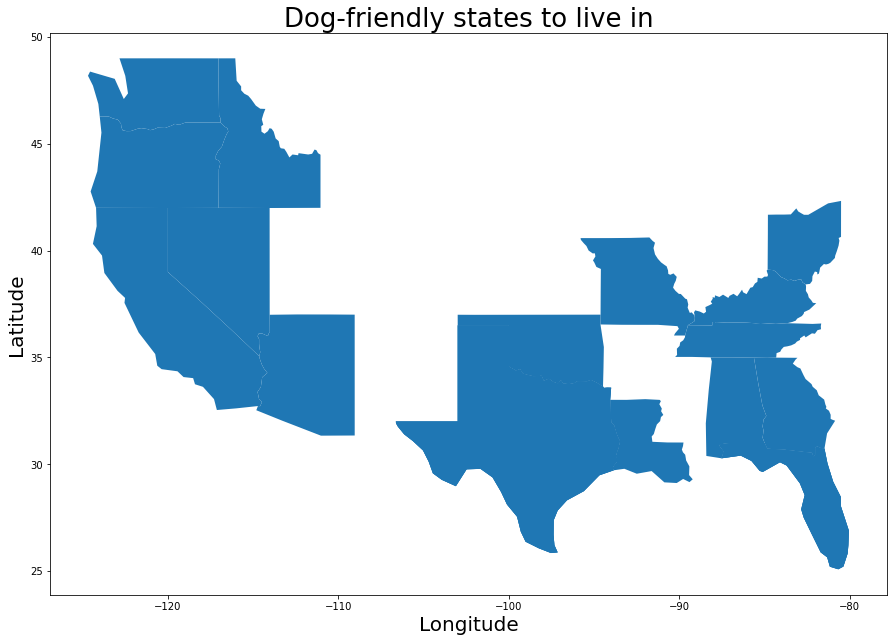

In [45]:
fig, ax = plt.subplots(figsize = (15,15))
merged_dogs.plot(ax=ax)
ax.set_title('Dog-friendly states to live in',fontdict = {'fontsize': 26})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})

Text(0.5, 262.5601850198839, 'Longitude')

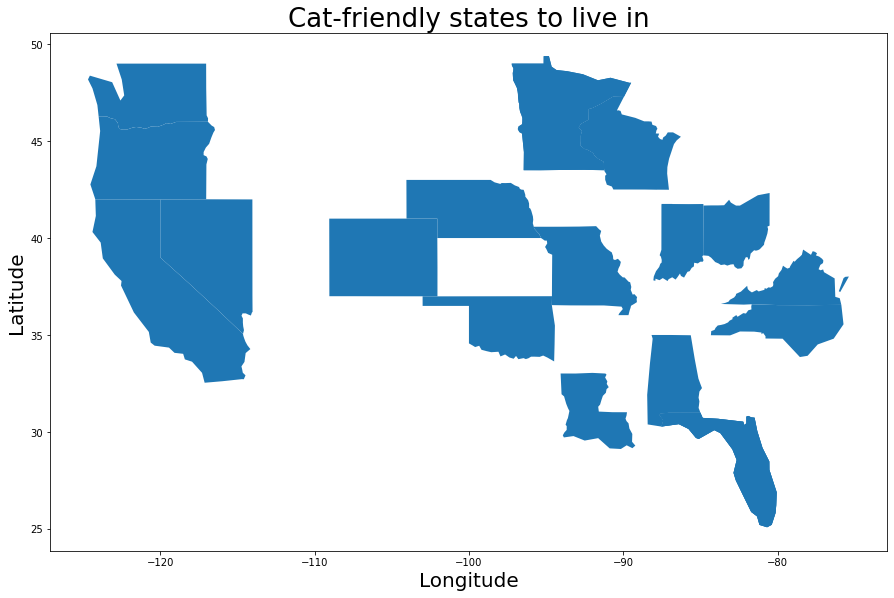

In [48]:
fig, ax = plt.subplots(figsize = (15,15))
merged_cats.plot(ax=ax)
ax.set_title('Cat-friendly states to live in',fontdict = {'fontsize': 26})
ax.set_ylabel('Latitude',fontdict = {'fontsize': 20})
ax.set_xlabel('Longitude',fontdict = {'fontsize': 20})